In [1]:
### original dataset visualization

def show_orgi_data(dataset_name):
    # import all packages
    import pandas as pd
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    # load data
    data = pd.read_csv(dataset_name, header=0, parse_dates=[0], index_col=0, squeeze=True)
    
    # show original data
    groups = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    i = 1
    # plot each column
    plt.figure(figsize=(15,20))
    for group in groups:
        plt.subplot(len(groups), 1, i)
        plt.plot(data.values[:, group])
        plt.title(data.columns[group], y=0.5, loc='right')
        i += 1
    plt.tight_layout()
    data.info()
    
    return data

In [2]:
### data pre-processing

def pre_processing(data):
    # check nonnull
    data = data.fillna(data.mean())
    
    # split the data to end up with the following dataframes: X_train,X_test,y_train, y_test
    from sklearn.model_selection import train_test_split
    
    data['NO2_reduction'] = data['NO2-2019'] - data['NO2-2020']
    X = data.drop(columns=['date','NO2-2019','NO2-2020','COVID-19 increased cases','COVID-19 increased deaths','Cumulative_number_for_14_days_of_COVID-19_cases_per_100000'])
    y = data['NO2_reduction']
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)
    
    # standardscaler
    from sklearn.preprocessing import StandardScaler
    xscaler = StandardScaler()
    yscaler = StandardScaler()
    X_train_scaled = xscaler.fit_transform(X_train)
    X_test_scaled = xscaler.transform(X_test)
    y_train_scaled = yscaler.fit_transform(y_train.values.reshape(-1,1))
    y_test_scaled = yscaler.transform(y_test.values.reshape(-1,1))
    
    # perform a boxplot of X_train_scaled here
    import seaborn as sns
    import matplotlib.pyplot as plt
    %matplotlib inline
    ax = sns.boxplot(data=X_train)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=80)
    ax.set_title("original data distribution")
    plt.show()
    
    ax = sns.boxplot(data=X_train_scaled)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=80)
    ax.set_title("pre_processing data distribution")
    plt.show()
   
    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled

In [3]:
def plot_model_history(history, ax=None, metric='loss', ep_start=1, ep_stop=None, monitor='val_loss', mode='min', plttitle=None):
    import numpy as np
    import matplotlib.pyplot as plt
    if ax is None:
        fig,ax = plt.subplots()
    if ep_stop is None:
        ep_stop = len(history.epoch)
    if plttitle is None:
        plttitle = metric[0].swapcase() + metric[1:] + ' During Training'
    ax.plot(np.arange(ep_start,ep_stop+1, dtype='int'),history.history[metric][ep_start-1:ep_stop])
    ax.plot(np.arange(ep_start,ep_stop+1, dtype='int'),history.history['val_' + metric][ep_start-1:ep_stop])
    ax.set(title=plttitle)
    ax.set(ylabel=metric[0].swapcase() + metric[1:])
    ax.set(xlabel='Epoch')
    ax.legend(['train', 'val'], loc='upper right')

In [4]:
### plot learning curve
def plot_learning_curves(model, X_train, X_test, y_train, y_test):
    from sklearn.metrics import mean_squared_error
    from sklearn.model_selection import train_test_split
    import matplotlib.pyplot as plt
    import numpy as np
    %matplotlib inline
    
    train_errors, test_errors = [], []
    for m in range(10, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_test_predict = model.predict(X_test)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        test_errors.append(mean_squared_error(y_test, y_test_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(test_errors), "b-", linewidth=3, label="test")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)              # not shown
    plt.show()

In [5]:
### plot observed data and predicted data for NNs model
def plot_residual_nns(model, X_train, X_test, y_train, y_test):
    from sklearn.metrics import mean_squared_error, r2_score
    import seaborn as sns
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline

    y_pred_train = np.concatenate(model.predict(X_train).astype('float'))
    y_pred_test = np.concatenate(model.predict(X_test).astype('float'))

    print("RMSE training fit: %.03f" %np.sqrt(mean_squared_error(y_train,y_pred_train)))
    print("R2 training fit: %.03f " %r2_score(y_train,y_pred_train))
    print("RMSE prediction: %.03f" %np.sqrt(mean_squared_error(y_test,y_pred_test)))
    print("R2 prediction: %.03f " %r2_score(y_test,y_pred_test))

    minlim = y_test.min()
    maxlim = y_test.max()
    # predicted/actual plot for test set
    ax = sns.jointplot(x=y_test.reshape(-1,1),y=y_pred_test.reshape(-1,1), height=5,xlim=(minlim,maxlim),ylim=(minlim,maxlim))
    ax.ax_joint.set_xlabel('observed csMPa')
    ax.ax_joint.set_ylabel('predicted csMPa')
    plt.figure()
    sns.distplot(y_test-y_pred_test)
    plt.xlabel('Residuals')
    plt.show()

In [6]:
### Model 8: NNs
def nns_model(X_train, X_test, y_train, y_test, epochs = 20, batch_size = 256):
    from sklearn.model_selection import train_test_split
    from keras import regularizers
    from keras.models import Sequential
    from keras.layers import Dense, Dropout
    from keras.callbacks import EarlyStopping
    
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=X_train.shape[1:]))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation="linear", name="output"))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['MeanSquaredError'])
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)
    history_nns = model.fit(X_train, y_train, validation_split=0.25, epochs=epochs, callbacks=[es], verbose=0)

#     plot_learning_curves(model, X_train, X_test, y_train, y_test)
    plot_residual_nns(model, X_train, X_test, y_train, y_test)
    plot_model_history(history_nns, plttitle='NNs')

In [7]:
### complete pipeline

def main(dataset_name,model_name):
    ### Pipeline: 1. show original data
    data = show_orgi_data(dataset_name)
    
    ### Pipeline: 2. data pre-processing
    X_train, X_test, y_train, y_test = pre_processing(data)
    
    ### Pipeline: 3. model selection
    if model_name == 'nns':
        nns_model(X_train, X_test, y_train, y_test)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233 entries, 0 to 232
Data columns (total 11 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   date                                                        233 non-null    object 
 1   Fossil hard coal[MWh]                                       233 non-null    int64  
 2   Fossil brown coal[MWh]                                      233 non-null    int64  
 3   Fossil gas[MWh]                                             233 non-null    int64  
 4   Biomass[MWh]                                                233 non-null    int64  
 5   NO2-2019                                                    233 non-null    float64
 6   NO2-2020                                                    233 non-null    float64
 7   covid-policy-stringency-index                               233 non-null    float64
 8   

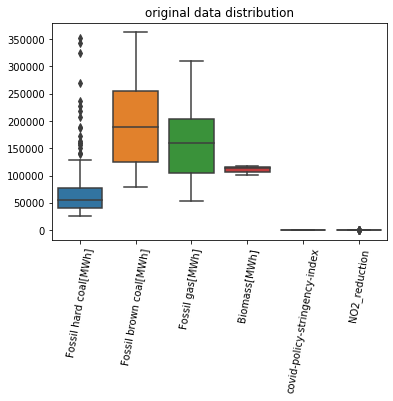

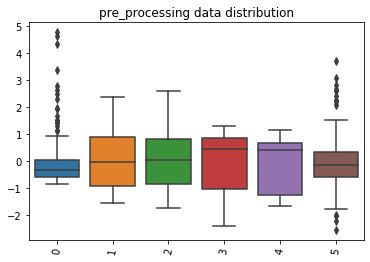

RMSE training fit: 0.140
R2 training fit: 0.980 
RMSE prediction: 0.157
R2 prediction: 0.974 


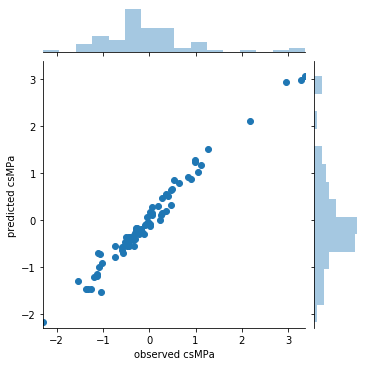

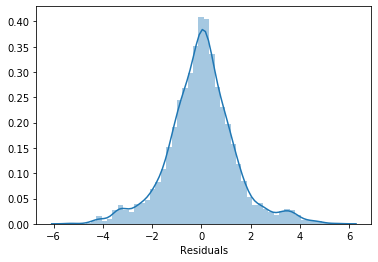

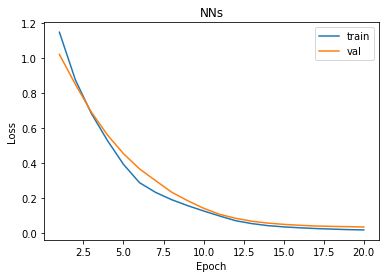

In [8]:
dataset_name = 'AMI_Data.csv'
model_name = 'nns'
main(dataset_name,model_name)